In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

import re
from parser import parse_filename, natural_sort
import pandas as pd

from IPython import display
import time
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [3]:
ref_file = '../analysis/refs/pnas2016.csv'
ref_df = pd.read_csv(ref_file, delimiter=r"\s+")
ref_df

,T,rs,etot,p,k,vtot,f,s
0,1200,1.34,-0.51592,269.0,NaN,-1.3083,NaN,NaN
1,1200,1.35,-0.51813,257.7,NaN,NaN,NaN,NaN
2,1200,1.36,-0.51980,243.1,NaN,NaN,NaN,NaN
3,1200,1.37,-0.52200,232.5,NaN,NaN,NaN,NaN
4,1200,1.38,-0.52560,234.1,NaN,NaN,NaN,NaN
5,1200,1.39,-0.52700,224.0,NaN,NaN,NaN,NaN
6,1200,1.40,-0.53010,218.5,NaN,NaN,NaN,NaN
7,1200,1.41,-0.53175,206.9,NaN,NaN,NaN,NaN
8,1200,1.42,-0.53353,198.5,NaN,NaN,NaN,NaN
9,1200,1.43,-0.53540,189.5,NaN,NaN,NaN,NaN


In [15]:
T, rs = 6000, 1.25

nicknames = [#'ff35520-r-fixk0-backflow', 
             #'ff35520-r-fixk0-backflow-pbc',
             #'ff35520-r-fixk0-backflow-tabc-222',
             #'ff35520-r-fixk0-backflow-tabc-222-learnf',
             #'ff35520-r-fixk0-backflow-tabc-222-feature',
             #'ff35520-r-fixk0-backflow-tabc-w', 
             #'ff35520-r-fixk0-backflow-tabc-123',
             #'ff35520-r-fixk0-backflow-tabc-456',
             #'ff35520-r-backflow-tabc-w-feature-learnf', 
             #'ff35520-r-fixk0-backflow-pbc-feature-learnf',
             'ff35520-r-fixk0-backflow-tabc-w-feature-learnf',
             'ff35520-r-fixk0-backflow-tabc-w-feature-learnf-pbc',
             #'ff35520-r-fixk0-backflow-tabc-w-feature-learnf-van',
             #'ff35520-r-fixk0-backflow-tabc-b-feature-learnf',
             #'ff35520-r-fixk0-backflow-tabc-w-zeroinit',
             #'ff35520-r-fixk0-backflow-tabc-w-zeroinit-softplus'
             #'walker-uniform-geminal-fixsr-logj-float64-decay-compact-123',
             #'walker-uniform-geminal-fixsr-logj-float64-decay-compact-456'
             ]
             #'ff35520-r-fixk0-backflow-tabc-222-real',
             #'ff35520-r-fixk0-backflow-tabc-bw']
             #'ff35520-r-fixk0']#, 'ff35520', 'ff35520-r']
#nicknames += ['walker-uniform-geminal-fixsr-logj-float64-decay-compact-baldereschi-trs-complex']#, 'walker-fermi-geminal']#, 'walker-uniform']#, 'bootstrap'] #'walker-uniform-jastrow-geminal']#, 'walker-yukawa-nobeta', 'walker-yukawa-nobeta-pretrain'] #, 'van', 'van-pretrain', 'van-pretrain-gelu',  'van-pretrain-unshare', 'van-pretrain-unshare-gelu'] #, 'van' ] #, 'walker', ]#, 'jastrow-tabc-rint-yukawa'] #'jastrow-yukawa',  'jastrow-uniform'] #, 'jastrow-tabc-rint-h2', 'jastrow-tabc-rint-yukawa-nobeta', 'jastrow-tabc-uniform', 'jastrow-tabc-rint-soft'] #, #, 'atom-positive-alpha', ] #'atom-exp-alpha'] #, #, 'atom-equivariant'] # 'atom']
#nicknames += ['walker-uniform-geminal-fixsr-logj-float64-decay-compact-twist']
#nicknames += ['walker-uniform-geminal-fixsr-logj-float64-decay-compact-bw']

files = []
for nickname in nicknames:
    files += glob("../data/"+nickname+"/n_54*_dim_3_rs_%g*_T_%g_*/data.txt"%(rs, T))
files = list(filter(lambda f: os.path.getsize(f)>100, files))
files = natural_sort(files)
#files = files[::-1]

#files += ['/data/wanglei/hydrogen/walker-uniform-geminal/n_14_dim_3_rs_1.44_T_1200_fs_1_fd_3_fh1_64_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_4_nk_7_Gmax_15_kappa_10_mctherm_10_mcsteps_100_500_mcwidth_0.02_0.04_lr_1_0.05_decay_0.01_damping_0.001_norm_0.001_clip_5_ws_1024_bs_8192_devices_8_accsteps_1/data.txt']
#files += ['/data/wanglei/hydrogen/jastrow-tabc-rint-yukawa/n_14_dim_3_rs_1.2_T_10000_fs_1_fd_3_fh1_64_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.03_0.03_lr_0.05_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt']
#files += ['/data/wanglei/hydrogen/jastrow/n_54_dim_3_rs_1.44_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.02_lr_0.05_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_256_devices_8_accsteps_4/data.txt']
#files += ['/data/wanglei/hydrogen/jastrow/n_54_dim_3_rs_1.2_T_1000_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.02_lr_0.05_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_64_devices_1_accsteps_16/data.txt']
#files += ['/data/wanglei/hydrogen/jastrow/n_14_dim_3_rs_1.2_T_1000_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_8_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.05_lr_0.1_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt']
len(files)

8

In [169]:
def cond(f):
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
    #return rs <1.46 and '_ht_' not in f and ('nk_19' in f) and ('mcsteps_100_400' in f) 
    #return ('mcsteps_100_500' in f or 'mcsteps_100_400' in f) 
    #return not 'mctherm_100' in f and w >128
    return rs == 1.4 and b == 8192
files = list(filter(cond , files))
files = files[::-1]
len(files)

#files = [files[2], files[1]]
#files = [files[0], files[2], files[1], files[3], files[4]]
#files = files[-2:]

0

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_16_fh2_16_wd_3_wh1_16_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_1000_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_512_bs_8192_accsteps_1/data.txt 0.05700255485450858
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_128_bs_1024_accsteps_1/data.txt 0.05700255485450858
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_1/data.txt 0.05700255485450858
../data/ff3

(-1.0, -0.8)

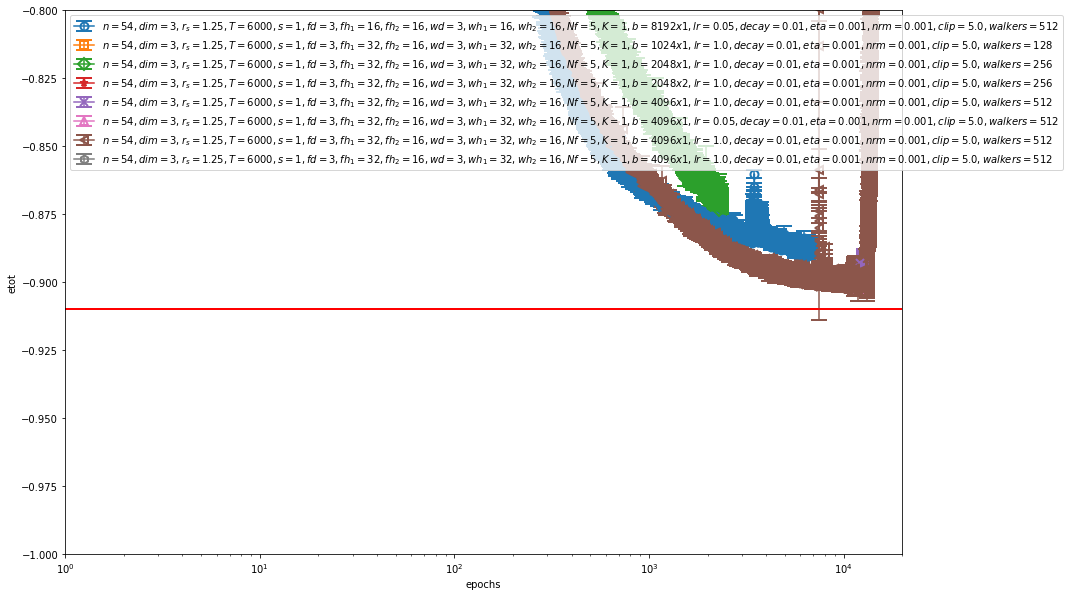

In [24]:
obs = 'etot'

markers = ['o', 's', 'D', '*', 'x', '^', '<', 'h', '>', 'd', 'X', 'v', 'h', '1']
colors = ['C0', 'C1','C2', 'C3', 'C4', 'C6', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']

plt.figure(figsize=(15,10))
for f, marker, color in zip(files, markers, colors):
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
      
    Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 
    
    print (f, Kp)
    df = pd.read_csv(f, delimiter=r"\s+")
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,fd=%s,fh_1=%s,fh_2=%s,wd=%s,wh_1=%s,wh_2=%s,Nf=%s,K=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s,clip=%s, walkers=%s$'\
                %(n,dim,rs,T,s,fd,fh1,fh2,wd,wh1,wh2,Nf,K,b,a,lr,decay,eta,maxnorm,clip,w)
  
    if obs == 'f':
        y = df[obs].values + Kp
        yerr = df['f_err'].values
    elif obs == 'vtot':
        y = df['vpp'].values + df['vep'].values + df['vee'].values
        yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)       
    elif obs == 'etot':
        y = df['e'].values + df['vpp'].values + Kp
        yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    elif obs in ['acc_s', 'acc_x']:
        y = df[obs].values
        yerr = np.zeros_like(y)
    elif obs == 'p':
        L = (4/3*jnp.pi*n)**(1/3)
        y = df[obs].values + (2*Kp)/(3*(L*rs)**3)*14710.513242194795
        yerr = df[obs+'_err'].values
    else:
        y, yerr = df[obs].values, df[obs+'_err'].values
    
    #L = (4/3*np.pi*n)**(1/3)
    #y -= ( jax.scipy.special.gammaln(n+1)/n + dim*np.log(L) )

    try:
        ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))[obs].values[0]
        if obs in ['etot', 'k', 'vtot', 'f']: ref_value = 2*ref_value 
        plt.axhline(y=ref_value, color='r')
        #y = (y-ref_value)/np.abs(ref_value) 
          
    except (KeyError , IndexError):
        print ('no ref data')
        
    plt.errorbar(df['epoch'].values, y, yerr=yerr,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=8, capsize=8, label=label)

    #if obs == 'p': plt.ylim([100, 400])
    #if obs in ['f', 'etot', 'e', 'vtot']: plt.ylim([1, 2])

plt.ylabel(obs)
plt.xlabel('epochs')
plt.xlim([1, 2e4])
plt.xscale('log') 
#plt.yscale('log') 
plt.legend(loc='upper left')
#plt.ylim([-20, 20])
plt.ylim([-1.0, -0.8])
#plt.ylim([400, 600])
#plt.axhline(y=200, color='r')
#plt.axhline(y=-0.8772, color='r')
#plt.axvline(x=346, color='r')

In [18]:
import sys, os
sys.path.append("../src")
from checkpoint import find_ckpt_filename, load_data

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.2_T_5000_fs_1_fd_3_fh1_16_fh2_16_wd_3_wh1_16_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_2/epoch_005047.pkl


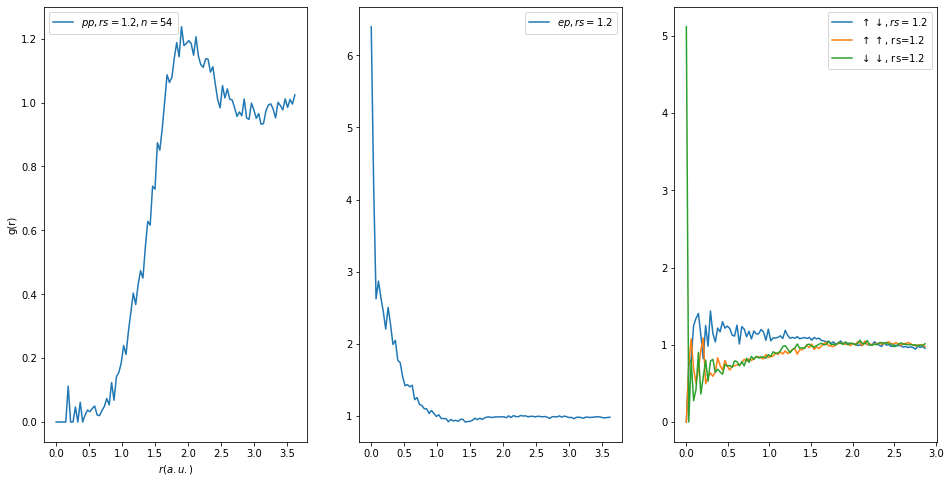

In [142]:
def get_gr(x, y): 
    batchsize, n, dim = x.shape[0], x.shape[1], x.shape[2]
    
    if dim == 3:
        L = (4/3*np.pi*n)**(1/3)
    elif dim == 2:
        L = np.sqrt(jnp.pi*n)
        
    i,j = np.triu_indices(n, k=1)
    rij = (np.reshape(x, (-1, n, 1, dim)) - np.reshape(y, (-1, 1, n, dim)))[:,i,j]
    rij = rij - L*np.rint(rij/L)
    dist = np.linalg.norm(rij, axis=-1) # (batchsize, n*(n-1)/2)
   
    hist, bin_edges = np.histogram(dist.reshape(-1,), range=[0, L/2], bins=100)
    dr = bin_edges[1] - bin_edges[0]
    hist = hist*2/(n * batchsize)

    rmesh = np.arange(hist.shape[0])*dr
    
    h_id = 4/3*np.pi*n/(L**3)* ((rmesh+dr)**3 - rmesh**3 )
    return rmesh*rs, hist/h_id

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

for f in files:
    
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
    
    ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))
    ckpt_files = [ckpt_file]
    
    #path = os.path.dirname(f)
    #ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if ('pkl' in f)]
    
    for ckpt_file in ckpt_files:
        if ckpt_file is None: continue
        print (ckpt_file)
        data = load_data(ckpt_file)
    
        s, x = data['s'], data['x']
        
        n, dim = x.shape[-2], x.shape[-1]
        s = s.reshape(-1, n, dim)
        x = x.reshape(-1, n, dim)
        
        walkersize, batchsize = s.shape[0], x.shape[0]
        if (walkersize != batchsize):
            s = jnp.repeat(s, batchsize//walkersize, 0)

        rmesh, gr = get_gr(s, s)
        ax1.plot(rmesh, gr, label=r'$pp, rs=%g,n = %g$'%(rs, n))
        #rmesh, gr = get_gr(x, x)
        #ax1.plot(rmesh, gr, label=r'$ee, rs=%g$'%rs)
  
        rmesh, gr = get_gr(s, x)
        ax2.plot(rmesh, gr, label=r'$ep, rs=%g$'%rs) 
        
        #ax1.set_yscale('log') 
        #ax1.plot(rmesh, 3*np.exp(-rmesh))
            
        rmesh, gr = get_gr(x[:, :n//2], x[:, n//2:])
        ax3.plot(rmesh, gr, label=r'$\uparrow\downarrow, rs=%g$'%rs)
        rmesh, gr = get_gr(x[:, :n//2], x[:, :n//2])
        ax3.plot(rmesh, gr, label=r'$\uparrow\uparrow$, rs=%g'%rs)
        rmesh, gr = get_gr(x[:, n//2:], x[:, n//2:])
        ax3.plot(rmesh, gr, label=r'$\downarrow\downarrow$, rs=%g'%rs)
        
        #ax2.set_yscale('log') 
 
ax1.set_xlabel('$r(a.u.)$')
ax1.set_ylabel('g(r)')
ax1.legend()
ax2.legend()
ax3.legend()   

In [19]:
from hf import Hydrogen

f = '/data/wanglei/hydrogen/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_16_dim_3_rs_1.34_T_1200_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_33_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_512_bs_4096_accsteps_1/data.txt'

walkersize = 8
if True:
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
    ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))
 
    print (ckpt_file)
    data = load_data(ckpt_file)
    s = data['s']
        
    n, dim = x.shape[-2], x.shape[-1]
    s = s.reshape(-1, n, dim)
        
    scf = [Hydrogen(rs * L, rs * np.array(p)) for p in s[:walkersize]]
    
    K = np.array([scf[w].K()/n for w in range(walkersize)])
    Vep = np.array([scf[w].Vep()/n for w in range(walkersize)])
    Vee = np.array([scf[w].Vee()/n for w in range(walkersize)])
    Vpp = np.array([scf[w].Vpp()/n for w in range(walkersize)])
    E_elec = np.array([scf[w].E_elec()/n for w in range(walkersize)])
    E = np.array([scf[w].E()/n for w in range(walkersize)])
    print ('kinetic energy', K, K.mean(), K.std()/np.sqrt(walkersize))
    print ('Vep', Vep,  Vep.mean(), Vep.std()/np.sqrt(walkersize))
    print ('Vee', Vee,  Vee.mean(), Vee.std()/np.sqrt(walkersize))
    print ('Vpp', Vpp,  Vpp.mean(), Vpp.std()/np.sqrt(walkersize))
    print ('electron energy', E_elec,  E_elec.mean(), E_elec.std()/np.sqrt(walkersize))
    print ('total energy', E,  E.mean(), E.std()/np.sqrt(walkersize))
    

ModuleNotFoundError: No module named 'pyscf'

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_1/data.txt
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_1/epoch_000040.pkl
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_1/epoch_000859.pkl
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim

Text(0.5, 0, 'epochs')

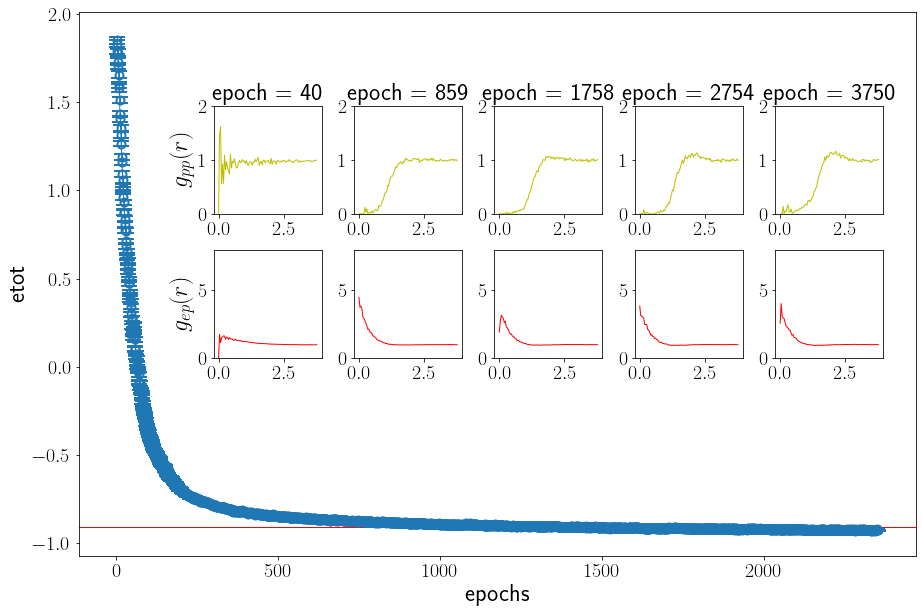

In [403]:
files = [files[2]]
obs = 'etot'
markers = ['o', 's', 'D', '*', 'x', '^', '<', 'h', '>', 'd', 'X', 'v', 'h', '1']
colors = ['C0', 'C1','C2', 'C3', 'C4', 'C6', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']


fig = plt.figure(figsize=(15,10))
ax = plt.gca()
for f, marker, color in zip(files, markers, colors):
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
  
    print (f)
    df = pd.read_csv(f, delimiter=r"\s+")
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,fd=%s,fh_1=%s,fh_2=%s,wd=%s,wh_1=%s,wh_2=%s,Nf=%s,K=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s,clip=%s, walkers=%s$'\
                %(n,dim,rs,T,s,fd,fh1,fh2,wd,wh1,wh2,Nf,K,b,a,lr,decay,eta,maxnorm,clip,w)
  
    if obs == 'vtot':
        y = df['vpp'].values + df['vep'].values + df['vee'].values
        yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)       
    elif obs == 'etot':
        y = df['e'].values + df['vpp'].values
        yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    elif obs in ['acc_s', 'acc_x']:
        y = df[obs].values
        yerr = np.zeros_like(y)
    else:
        y, yerr = df[obs].values, df[obs+'_err'].values
        
    ax.errorbar(df['epoch'].values, y, yerr=yerr,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=8, capsize=8, label=label)

    try:
        ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))[obs].values[0]
        if obs in ['etot', 'k', 'vtot']: ref_value = 2*ref_value 
        plt.axhline(y=ref_value, color='r')
                
    except KeyError or IndexError:
        print ('no ref data')
        
    #if obs == 'p': plt.ylim([100, 400])
    #if obs in ['f', 'etot', 'e', 'vtot']: plt.ylim([1, 2])
    
    
    path = os.path.dirname(f)
    ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if ('pkl' in f)]
    ckpt_files = natural_sort(ckpt_files)
    skips = len(ckpt_files)//4
    
    for offset, ckpt_file in enumerate(ckpt_files[::skips]):
        if ckpt_file is None: continue
        print (ckpt_file)
        data = load_data(ckpt_file)
        epoch = int(re.search('epoch_([0-9]*).pkl', ckpt_file).group(1))
    
        s, x = data['s'], data['x']
        
        n, dim = x.shape[-2], x.shape[-1]
        s = s.reshape(-1, n, dim)
        x = x.reshape(-1, n, dim)
        
        walkersize, batchsize = s.shape[0], x.shape[0]
        if (walkersize != batchsize):
            s = jnp.repeat(s, batchsize//walkersize, 0)

        
        #rmesh, gr = get_gr(x, x)
        
        rmesh, gr = get_gr(s, s)
        left, bottom, width, height = [0.25+offset*0.13, 0.6, 0.1, 0.15]
        inset = fig.add_axes([left, bottom, width, height])
        inset.plot(rmesh, gr, 'y')
        inset.set_ylim([0, 2])
        plt.title(r'epoch = %g'%(epoch))
        if offset ==0: inset.set_ylabel('$g_{pp}(r)$')
        
        rmesh, gr = get_gr(s, x)
        left, bottom, width, height = [0.25+offset*0.13, 0.4, 0.1, 0.15]
        inset = fig.add_axes([left, bottom, width, height])
        inset.plot(rmesh, gr, 'r')
        inset.set_ylim([0, 8])
        if offset ==0: inset.set_ylabel('$g_{ep}(r)$')
        
        
ax.set_ylabel(obs)
ax.set_xlabel('epochs')
#plt.xlim([1, 1e5])
#plt.xscale('log') 
#plt.legend(loc='best')
#plt.ylim([-5, 5])

In [ ]:
f = files[0]
n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
  
ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))

print (ckpt_file)
data = load_data(ckpt_file)
    
s, x = data['s'], data['x']
n, dim = x.shape[-2], x.shape[-1]
s = s.reshape(-1, n, dim)
x = x.reshape(-1, n, dim)

L = (4/3*np.pi*n)**(1/3)
s = s - L*np.floor(s/L)
x = x - L*np.floor(x/L)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(projection='3d')

b = 100

ax.scatter(s[b, :, 0], s[b, :, 1], s[b, :, 2], marker='o', color='k', s=200)
ax.scatter(x[b, :n//2, 0], x[b, :n//2, 1], x[b, :n//2, 2], marker='o', color='r', s=100)
ax.scatter(x[b, n//2:, 0], x[b, n//2:, 1], x[b, n//2:, 2], marker='o', color='b', s=100)

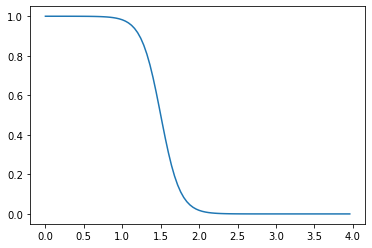

In [5390]:
def gc(r):
     return (np.tanh(-4*(r-1.5))+1)/2
plt.plot(rmesh, gc(rmesh))

In [3943]:
for f in files:
    
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf, clip, K = parse_filename(f)
    
    ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))

    print (ckpt_file)
    data = load_data(ckpt_file)
    
    s, x = data['s'], data['x']

    n, dim = x.shape[-2], x.shape[-1]
    s = s.reshape(-1, n, dim)
    x = x.reshape(-1, n, dim)
    batchsize = x.shape[0]
    
    rij = (np.reshape(s, (-1, n, 1, dim)) - np.reshape(s, (-1, 1, n, dim)))
    rij = rij - L*np.rint(rij/L)
    r = np.linalg.norm(rij, axis=-1)
    r = r + 1e10*np.eye(n, n)[None, ...]

    print (rs, np.mean(gc(rs*np.min(r, axis=-1))))

/data/wanglei/hydrogen/jastrow-tabc-soft/n_54_dim_3_rs_1.34_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_100_mcwidth_0.01_0.03_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_256_devices_8_accsteps_8/epoch_000354.pkl
1.34 0.7525673436291141
/data/wanglei/hydrogen/jastrow-tabc/n_54_dim_3_rs_1.34_T_1200_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_K_4_Gmax_15_kappa_10_mctherm_10_mcsteps_100_mcstddev_0.02_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_128_devices_4_accsteps_8/epoch_002424.pkl
1.34 0.490605326245736


6.092947785379555


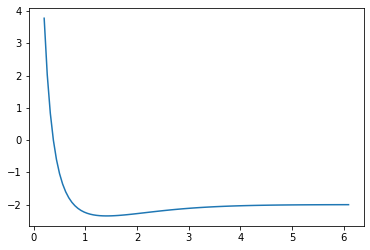

In [35]:
rs = 1.0
n = 54 
L = (4/3*np.pi*n)**(1/3)
print (L)

p = jnp.array([-1.0, 2.867, -5.819, -9.935, 4.456])
q = jnp.array([1.0, -3.005, 7.81, 2.104, 0.4839])

r = jnp.linspace(0.2, L, 100)
v = jnp.polyval(p, r*rs)/ jnp.polyval(q, r*rs)*2
plt.plot(r, v)

#epsilon = 2*0.18 
#sigma = 1.4/rs/(2**(1/6)) 
#v = 4*epsilon*((sigma/r)**12 - (sigma/r)**6) -2 
#plt.plot(r, v)

#plt.plot(r, np.exp(-rs*r))

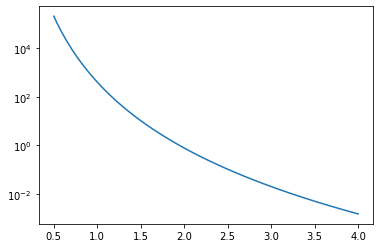

In [157]:
def softcore(r, eta=1, alpha=10, sigma = 1, epsilon = 1):
    #return eta**4*4*epsilon*(1/(alpha*(1-eta)**2 + (r/sigma)**6)**2 - 1/(alpha*(1-eta)**2 + (r/sigma)**6))
    return 4*epsilon * (sigma/r)**9 *100
    #return np.exp(-r)
    #return np.log(1+np.exp(alpha*(1-r)))
r = jnp.linspace(0.5, 4, 100)   
plt.plot(r, softcore(r))
plt.yscale('log')
#plt.plot(r, np.exp(-r)*100)

In [66]:
import sys
sys.path.append("../src/")

In [67]:
from sampler import make_base
from mcmc import mcmc 
from utils import shard 

In [1915]:
def test_mcmc(rs):
    beta = 157888.088922572/1000
    print ('beta', beta)
    n = 14
    dim = 3
    batchsize = 1024
    
    mc_therm = 10
    mc_steps = 100
    mc_width = 0.02
    L = (4/3*jnp.pi*n)**(1/3)
    
    import math 
    import itertools
    def cubic_init(n,spacing):
        K = math.ceil(n**(1 / 3))
        x = np.linspace(0, K * spacing, K, endpoint=False)
        position = list(itertools.product(x, repeat=3))
        return np.array(position[:n])
    
    def mean_dist(z):
        z = z - L * jnp.floor(z/L)
        i, j = jnp.triu_indices(n, k=1)
        rij = (jnp.reshape(z, (n, 1, dim)) - jnp.reshape(z, (1, n, dim)))[i, j]
        r = jnp.linalg.norm(rij, axis=-1)
        return jnp.mean(r)

    logprob = make_base(n, dim, L, beta, rs)
    logprob = jax.vmap(logprob)

    key = jax.random.PRNGKey(42)
        
    num_devices = jax.device_count()
    if batchsize % num_devices != 0:
        raise ValueError("Batch size must be divisible by the number of GPU devices. "
                         "Got batch = %d for %d devices now." % (args.batch, num_devices))
    batch_per_device = batchsize // num_devices

    s = jax.random.uniform(key, (num_devices, batch_per_device, n, dim), minval=0, maxval=10)

    #s = cubic_init(n, 1.4/rs) # (n, dim)
    #s = s[None, None, :, :] + 0.1*jax.random.normal(key, (num_devices, batch_per_device, n, dim)) 
    #s -= L * jnp.floor(s/L)
    
    keys = jax.random.split(key, num_devices)
    s, keys = shard(s), shard(keys)
    
    mcmc_p = jax.pmap(mcmc, axis_name="p", in_axes=(None, 0, 0, None, None), static_broadcasted_argnums=(0,))
    
    for i in range(mc_therm):

        rmesh, gr = get_gr(s.reshape(-1, n, dim), s.reshape(-1, n, dim))
        plt.plot(rmesh, gr)
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.1)
        
        s, acc_rate = mcmc_p(logprob, s, keys, mc_steps, mc_width) 
        s -= L * jnp.floor(s/L)
        r_mean = jnp.mean(jax.vmap(mean_dist)(s.reshape(batchsize, n, dim)))
        print (i, acc_rate, r_mean, -logprob(s.reshape(batchsize, n, dim)).mean()/n)
        

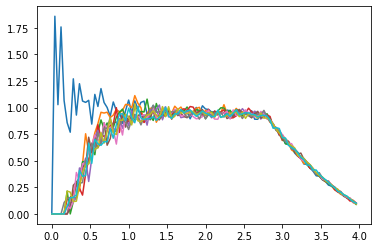

9 [0.96082031] 2.5840263305435616 0.277223030845644


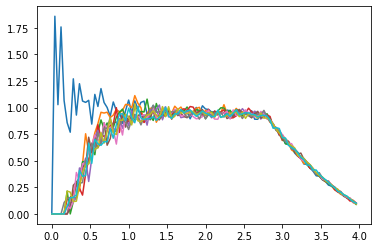

In [1916]:
test_mcmc(rs = 1.44)